### Extracting datetime from raw item column

In [ ]:
import ast, re
import pandas as pd
import numpy as np

df = pd.read_csv(r".\delhi_pm25_features.csv", dtype=str)

# Parsing datetime from _raw_item 
def extract_datetime(s):
    if pd.isna(s):
        return None
    try:
        d = ast.literal_eval(s)
        cov = d.get('coverage') or {}
        return (cov.get('datetimeFrom') or {}).get('utc') or (cov.get('datetimeTo') or {}).get('utc')
    except Exception:
        m = re.search(r"\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}Z", s or "")
        return m.group(0) if m else None

df['datetime_utc'] = pd.to_datetime(df['_raw_item'].apply(extract_datetime), utc=True, errors='coerce')
df = df.drop(columns=['_raw_item'])  


In [3]:
df['datetime_utc'].count()

80709

In [4]:
df.head()

,pm25_hourly,n_obs_hour,latitude,longitude,temperature,relative_humidity,wind_speed,hour,sin_hour,cos_hour,...,pm25_lag_1h,pm25_lag_3h,pm25_lag_24h,pm25_roll_mean_24h,location_id,lat,lon,location_id_code,is_holiday,datetime_utc
0,297.0,NaN,28.63576,77.22445,NaN,NaN,NaN,19,-0.9659258262890684,0.2588190451025203,...,NaN,NaN,NaN,297.0,8118,28.63576,77.22445,0,False,2016-11-09 19:00:00+00:00
1,307.0,NaN,28.63576,77.22445,NaN,NaN,NaN,20,-0.8660254037844386,0.5000000000000001,...,297.0,NaN,NaN,302.0,8118,28.63576,77.22445,0,False,2016-11-09 20:00:00+00:00
2,309.0,NaN,28.63576,77.22445,NaN,NaN,NaN,21,-0.7071067811865477,0.7071067811865474,...,307.0,NaN,NaN,304.3333333333333,8118,28.63576,77.22445,0,False,2016-11-09 21:00:00+00:00
3,315.0,NaN,28.63576,77.22445,NaN,NaN,NaN,22,-0.5000000000000004,0.8660254037844384,...,309.0,297.0,NaN,307.0,8118,28.63576,77.22445,0,False,2016-11-09 22:00:00+00:00
4,330.0,NaN,28.63576,77.22445,NaN,NaN,NaN,23,-0.25881904510252157,0.9659258262890681,...,315.0,307.0,NaN,311.6,8118,28.63576,77.22445,0,False,2016-11-09 23:00:00+00:00


In [ ]:
""" 
Time index , numeric types and choosing the target 
"""

# Dropping rows without a valid timestamp and setting index
df = df.dropna(subset=['datetime_utc']).copy()
df = df.set_index('datetime_utc').sort_index()

# Renaming pm2.5 column 
pm25_candidates = [c for c in df.columns if 'pm25' in c.lower().replace('.', '').replace('_', '')]
print("PM2.5 candidates:", pm25_candidates)

# rest of the columns
preferred_order = ['pm25_hourly', 'pm25', 'pm2_5', 'pm25value', 'pm25ugm3']
target_col = next((c for c in preferred_order if c in df.columns), None)
if target_col is None and pm25_candidates:
    target_col = pm25_candidates[0]

assert target_col is not None, "Couldn't find a PM2.5 column. Check your column names."

if target_col != 'pm25':
    df = df.rename(columns={target_col: 'pm25'})

print("Using target column:", 'pm25')

# Numeric columns
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# statistics
print("Index range:", df.index.min(), "→", df.index.max())
print("Rows:", len(df))
print(df[['pm25']].describe())

df.loc[df['pm25'] < 0, 'pm25'] = np.nan
df.loc[df['pm25'] > 5000, 'pm25'] = np.nan  


PM2.5 candidates: ['pm25_hourly', 'pm25_lag_1h', 'pm25_lag_3h', 'pm25_lag_24h', 'pm25_roll_mean_24h']
Using target column: pm25
Index range: 2016-11-09 19:00:00+00:00 → 2025-08-20 05:30:00+00:00
Rows: 80709
               pm25
count  75899.000000
mean      73.427509
std      236.958064
min     -999.000000
25%       33.000000
50%       64.000000
75%      138.000000
max     1990.000000


In [ ]:
# Resampling to hourly grid

# Handling duplicates
df = df[~df.index.duplicated(keep='first')]

# Reindexing
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h', tz='UTC')
df = df.reindex(full_index)

print("After resampling:")
print("Index range:", df.index.min(), "→", df.index.max())
print("Expected rows:", len(full_index), "Actual rows:", len(df))
print(df[['pm25']].isna().sum().rename('Missing values'))


After resampling:
Index range: 2016-11-09 19:00:00+00:00 → 2025-08-20 05:00:00+00:00
Expected rows: 76931 Actual rows: 76931
pm25    19842
Name: Missing values, dtype: int64


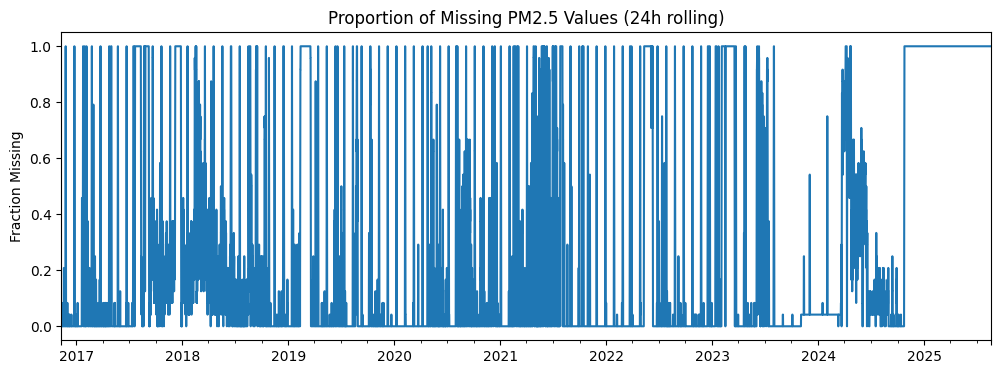

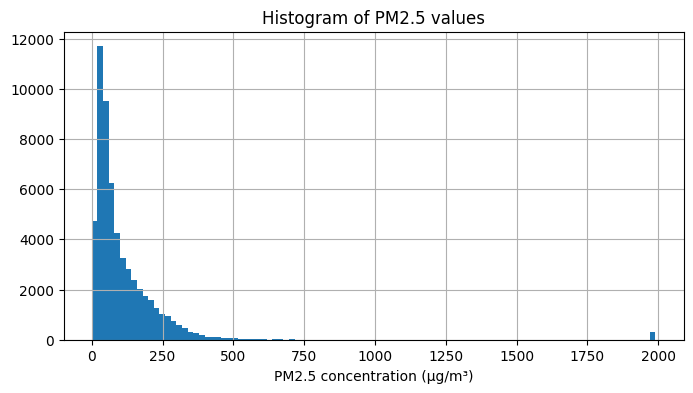

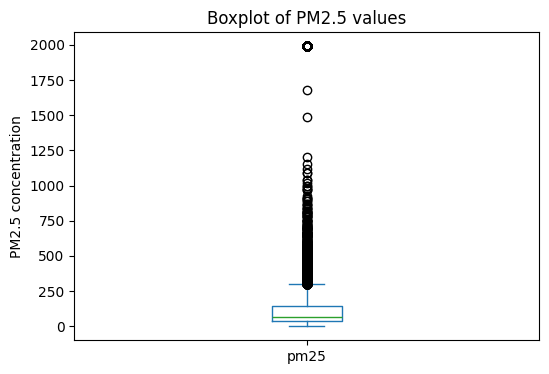

Number of invalid values (pm25 <= 0): 15
Number of very high spikes (pm25 > 1000): 301


In [ ]:
import matplotlib.pyplot as plt

# Missing values over time
plt.figure(figsize=(12,4))
df['pm25'].isna().astype(int).rolling(24).mean().plot()
plt.title("Proportion of Missing PM2.5 Values (24h rolling)")
plt.ylabel("Fraction Missing")
plt.show()

# Distribution of the pollutant
plt.figure(figsize=(8,4))
df['pm25'].dropna().hist(bins=100)
plt.title("Histogram of PM2.5 values")
plt.xlabel("PM2.5 concentration (µg/m³)")
plt.show()

# Outlier detection
plt.figure(figsize=(6,4))
df['pm25'].dropna().plot.box()
plt.title("Boxplot of PM2.5 values")
plt.ylabel("PM2.5 concentration")
plt.show()

# Extreme values
print("Number of invalid values (pm25 <= 0):", (df['pm25'] <= 0).sum())
print("Number of very high spikes (pm25 > 1000):", (df['pm25'] > 1000).sum())


# Data Exploration and Preprocessing

#### Before applying any cleaning or modeling steps, we conducted an exploratory data analysis (EDA) on the PM2.5 dataset to understand its quality, distribution, and missing value patterns.

#### Boxplot of PM2.5 values:
##### The boxplot revealed a highly skewed distribution with several extreme outliers. A significant number of values were clustered in the lower concentration range, while a few extreme points reached very high levels (>1500 µg/m³). Such outliers may distort statistical analysis and machine learning models if not handled appropriately.

#### Histogram of PM2.5 concentrations:
##### The histogram further confirmed the right-skewed nature of the data. Most of the PM2.5 concentrations were below 200 µg/m³, with a long tail extending up to nearly 2000 µg/m³. This suggests that while typical air quality levels are moderate to high, there are occasional extreme pollution events that create heavy tails in the distribution.

#### Proportion of missing values (24-hour rolling):
##### A time-series analysis of missing values revealed irregular gaps in the dataset. The missingness was not uniformly distributed: certain periods showed almost continuous reporting, while others had high fractions of missing values (close to 100%). Such patterns highlight the importance of careful imputation or exclusion strategies to maintain temporal consistency.

##### These initial findings justified the need for data cleaning. Specifically, the handling of outliers (to reduce skewness) and missing values (to ensure continuity) were identified as critical preprocessing steps. After cleaning, we re-examined the same plots to confirm improvements in data quality and reliability for further analysis.


# Cleaning


In [9]:
missing_pct = df['pm25'].isna().mean() * 100
print(f"Missing Percentage: {missing_pct:.2f}%")

Missing Percentage: 25.79%


In [ ]:
# Hazardous level by WHO are capped
q99 = df['pm25'].quantile(0.99)
df['pm25_clean'] = df['pm25'].clip(upper=q99)

# Resampling to daily for trend analyis without noise
df_daily = df['pm25_clean'].resample('D').mean()
df_monthly = df['pm25_clean'].resample('ME').mean()



In [12]:
#saving the data for future analyis
df.to_csv("pm25_cleaned.csv")
df_daily.to_csv("pm25_daily.csv")
